# Init

In [65]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [66]:
feature_type = "CA_inv" # "contacts_5_cutoff" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters", data.shape, len(set(cluster_indices)))


2018-11-08 16:33:17 beta2-INFO: Loaded data of shape (857, 40186) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [67]:
n_iterations, n_splits = 2, 10
rbm_data = np.copy(data)
np.random.shuffle(rbm_data)
feature_extractors = [
    #fe.MlpFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100, 50, 25)),
    fe.RbmFeatureExtractor(rbm_data, labels, n_splits=n_splits, n_iterations=n_iterations, n_components=32),
    #fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
    #fe.KLFeatureExtractor(data, labels, n_splits=n_splits),
    #fe.PCAFeatureExtractor(data, labels, n_splits=n_splits),
    #fe.RandomForestFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-11-08 16:33:32 beta2-INFO: Done. using 1 feature extractors


# Run the relevance analysis

In [68]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features(filter_results=True)
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-11-08 16:33:33 beta2-INFO: Computing relevance for extractors RBM
2018-11-08 16:33:38 Extracting feature-DEBUG: Iteration 1 of 20
2018-11-08 16:34:14 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:34:16 Extracting feature-DEBUG: Iteration 2 of 20
2018-11-08 16:34:53 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:34:55 Extracting feature-DEBUG: Iteration 3 of 20
2018-11-08 16:35:32 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:35:34 Extracting feature-DEBUG: Iteration 4 of 20
2018-11-08 16:36:12 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:36:14 Extracting feature-DEBUG: Iteration 5 of 20
2018-11-08 16:36:50 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:36:52 Extracting feature-DEBUG: Iteration 6 of 20
2018-11-08 16:37:28 Extracting feature-DEBUG: Computing feature importance on all data.
2018-11-08 16:37:

# Remap and persist results 

In [69]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, feature_to_resids=feature_to_resids)
    p.average()
    p.persist()
    postprocessors.append(p)

logger.info("Done")


2018-11-08 16:46:37 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-11-08 16:46:38 beta2-INFO: Done


# Visualize results

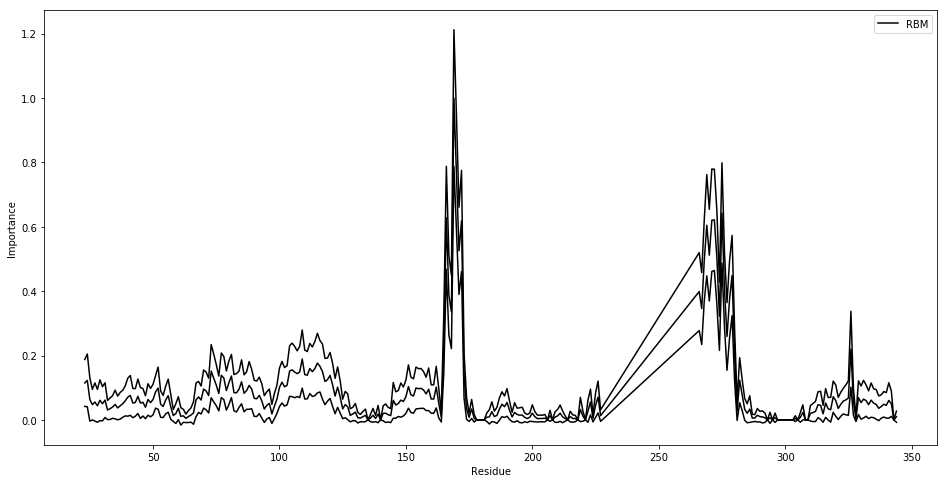

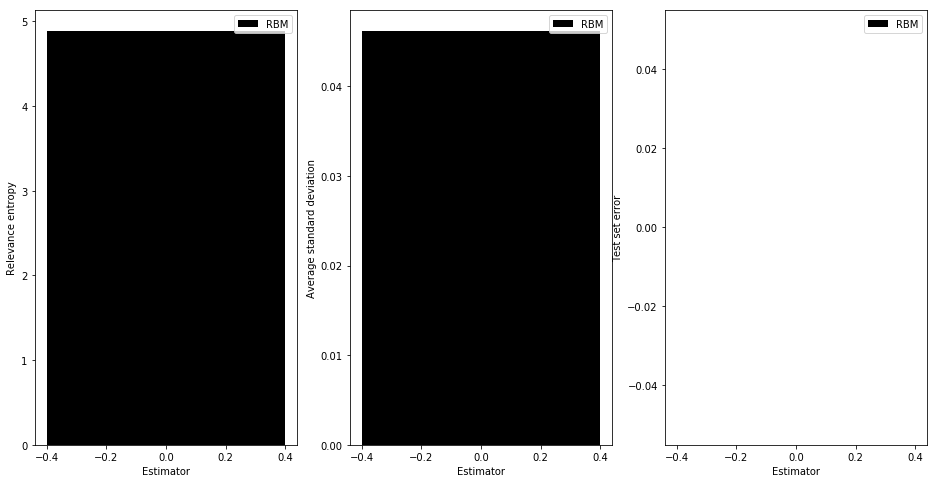

2018-11-08 16:46:38 beta2-INFO: Done


In [70]:
visualization.visualize(postprocessors)
logger.info("Done")